## Семинар 4: "Сверточные сети"

ФИО: Радионов Максим Анатольевич

In [3]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.sum(kernel[::-1] * signal[i:i+len(kernel)])
    
    """
    kernel_h = len(kernel) // 2
    for i in range(kernel_h, signal.shape[0] - kernel_h):
        k = i - kernel_h
        signal_convolved[k] = np.sum(kernel[::-1] * signal[i-kernel_h:i+kernel_h+1])
    """
        
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

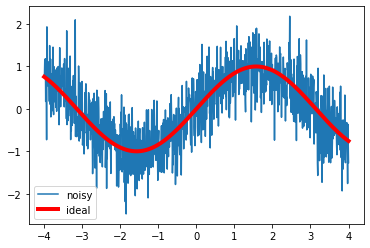

In [ ]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [ ]:
kernel = np.ones(71)
kernel /= kernel.shape[0]

denoised_signal = convolve(noisy_signal, kernel, 'same')

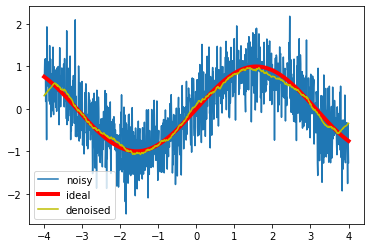

In [ ]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [ ]:
from sys import float_info
w = (2, float_info.max)
for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    if error < w[1]:
        w = (size, error)
print (w) 

(49, 0.008180016084361115)


#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

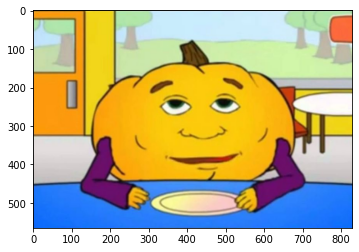

In [ ]:
image = plt.imread('1.jpg')
plt.imshow(image)

In [ ]:
image.shape

(565, 829, 3)

    <i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [ ]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140]).reshape(1,1,3)

In [ ]:
def t2_convolve(image, kernel):
    image_convolved = np.zeros((image.shape[0]-kernel.shape[0]+1,image.shape[1] - kernel.shape[0]+1)) 
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(image_convolved.shape[0]):
        for j in range(image_convolved.shape[1]):
            image_convolved[i][j] = np.sum(kernel * image[i : i + kernel.shape[0],j : j + kernel.shape[1]])
    return image_convolved

In [ ]:
image[2,3]

array([154, 109,  26], dtype=uint8)

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

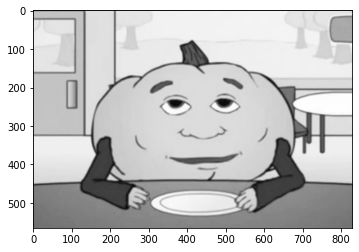

In [ ]:
bw_image = t2_convolve(image, color_to_bw)[:,:,np.newaxis]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

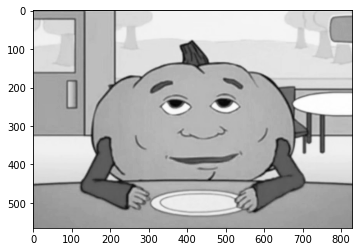

In [ ]:
plt.imshow(t2_convolve(image.mean(axis=-1), color_to_bw), cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [ ]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = t2_convolve(bw_image, kernel.reshape(3,3,1))
res_x = t2_convolve(bw_image, kernel.reshape(3,3,1))

In [ ]:
kernel.T

array([[[-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]]])

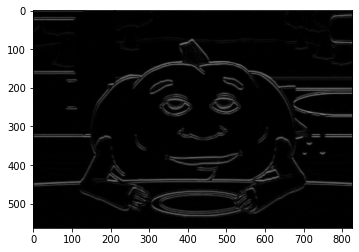

In [ ]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [ ]:
#[10, 30, 3] -> [10, 30, 4]
#[3, 3, 3, 4]

def t_convolve_bank(signal, kernel):
    assert signal.shape[-1] == kernel.shape[0]
    
    res = []
    for i in range(kernel.shape[-1]):
        r = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            r += convolve2d(signal[:, :, j], kernel[j, :, :, i], 'same')            
        
        res.append(r)
    
    return np.array(res).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [ ]:
#RGB -> BGR

kernels = np.zeros((3, 1, 1, 3))

kernels[0, 0, 0, 2] = 1
kernels[1, 0, 0, 1] = 1
kernels[2, 0, 0, 0] = 1
kernels

array([[[[0., 0., 1.]]],


       [[[0., 1., 0.]]],


       [[[1., 0., 0.]]]])

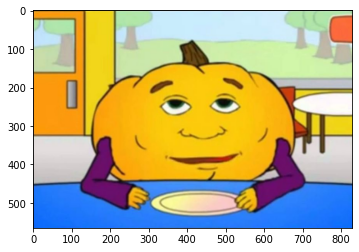

In [ ]:
image = plt.imread("1.jpg") 
plt.imshow(image)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

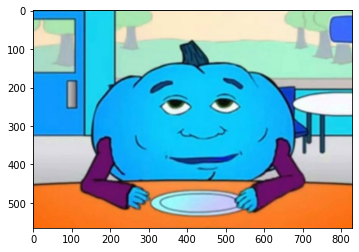

In [ ]:
res_image = t_convolve_bank(image.astype(float), kernels)

plt.imshow(res_image.astype('uint8'))

# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [ ]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    print(res.shape)
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[(i-w+1)//w, (j-w+1)//w, k] = np.max(image[i:i+w, j:j+w, k])
                
    return res
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[(i-w+1)//w, (j-w+1)//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res

In [ ]:
res_image=image

(70, 103, 3)


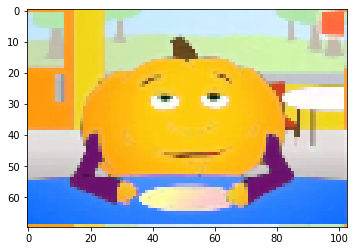

In [ ]:
res_image = maxpool(res_image.astype(float))

plt.imshow(res_image.astype('uint8'))

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

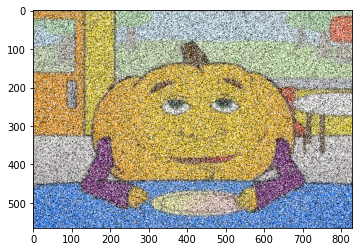

In [ ]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

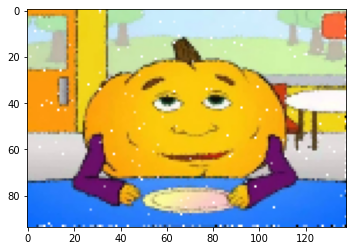

In [ ]:
clean_image = medianpool(res_image.astype(float), 6)

plt.imshow(clean_image.astype('uint8'))

(282, 414, 3)


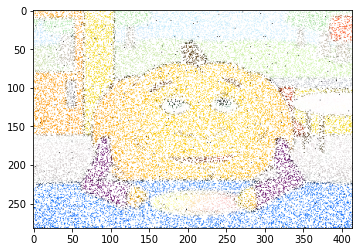

In [ ]:
clean_image = maxpool(res_image.astype(float), 2)

plt.imshow(clean_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

max пуллинг понятное дело будет выдавать одни белые точки

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [5]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
def _epoch(network, loss, loader,                                               
           backward=True,                                                       
           optimizer=None,                                                      
           device='cpu',                                                        
           ravel_init=False):                                                   
    losses = []                                                                 
    accuracies = []                                                             
    for X, y in loader:                                                         
        X = X.to(device)                                                        
        y = y.to(device)                                                        
        if ravel_init:                                                          
            X = X.view(X.size(0), -1)                                           
        network.zero_grad()                                                     
        prediction = network(X)                                                 
        loss_batch = loss(prediction, y)                                       
        losses.append(loss_batch.cpu().item())                                  
        if backward:                                                            
            loss_batch.backward()                                               
            optimizer.step()                                                    
        prediction = prediction.max(1)[1]                                       
        accuracies.append((prediction==y).cpu().float().numpy().mean())         
    return losses, accuracies  


def train(network, train_loader, test_loader,                                   
          epochs, learning_rate, loss=nn.MSELoss(), ravel_init=False,           
          device='cpu', tolerate_keyboard_interrupt=True, drop_epoch=0, adaptive_lr=False):                      
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)        
    train_loss_epochs = []                                                      
    test_loss_epochs = []                                                       
    train_accuracy_epochs = []                                                  
    test_accuracy_epochs = []   
    network = network.to(device)                                                
    try:                                                                        
        for epoch in range(epochs):                                             
            network.train()                                                     
            if adaptive_lr:
              if((1+epoch)%6 == 0):
                learning_rate = learning_rate/1.5
                for param_group in optimizer.param_groups:
                  param_group['lr'] = learning_rate
                print('change lr ', learning_rate)
            losses, accuracies = _epoch(network,                                
                                        loss,                                   
                                        train_loader,                           
                                        True,                                   
                                        optimizer,                              
                                        device,                                 
                                        ravel_init)                             

            if epoch >= drop_epoch: 
              train_loss_epochs.append(np.mean(losses))                           
              train_accuracy_epochs.append(np.mean(accuracies))                   

            network.eval()                                                      
            losses, accuracies = _epoch(network,                                
                                        loss,                                   
                                        test_loader,                            
                                        False,                                  
                                        optimizer,                              
                                        device,                                 
                                        ravel_init)                             
            clear_output(True)                                                  
            if epoch >= drop_epoch: 
              test_loss_epochs.append(np.mean(losses))                            
              test_accuracy_epochs.append(np.mean(accuracies))                    
              print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],     
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))   
            plt.figure(figsize=(12, 5))                                         
            plt.subplot(1, 2, 1)                                                
            plt.plot(train_loss_epochs, label='Train')                          
            plt.plot(test_loss_epochs, label='Test')                            
            plt.xlabel('Epochs', fontsize=16)                                   
            plt.ylabel('Loss', fontsize=16)                                     
            plt.legend(loc=0, fontsize=16)                                      
            plt.grid()                                                          
            plt.subplot(1, 2, 2)                                                
            plt.plot(train_accuracy_epochs, label='Train accuracy')             
            plt.plot(test_accuracy_epochs, label='Test accuracy')               
            plt.xlabel('Epochs', fontsize=16)                                   
            plt.ylabel('Accuracy', fontsize=16)                                 
            plt.legend(loc=0, fontsize=16)                                      
            plt.grid()                                                          
            plt.show() 
    except KeyboardInterrupt:                                                   
        if tolerate_keyboard_interrupt:                                         
            pass                                                                
        else:                                                                   
            raise KeyboardInterrupt                                             
    return train_loss_epochs, test_loss_epochs

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [34]:
image_size = 28
channels = 1
#input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
#input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax
class ConvClassifier1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
                                         nn.Conv2d(1, 8, 3, padding=1),  
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         
                                         nn.Conv2d(8,16, 3, padding=1), 
                                         nn.ReLU(),
                                        )
                                                 
        
        self.linear_layers = nn.Sequential(
                                           nn.Linear(3136, 10), 
                                           nn.LogSoftmax(dim=1)
                                           )
    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x) 
        return x

class ConvClassifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
                                         nn.Conv2d(1, 8, 3, padding=1),  
                                         nn.ReLU(),
                                         nn.Conv2d(8,16, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16,32, 3, padding=1), 
                                        )
                                                 
        
        self.linear_layers = nn.Sequential(
                                           nn.Linear(6272, 10), 
                                           nn.LogSoftmax(dim=1)
                                           )
    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x) 
        return x
        
class ConvClassifier3(nn.Module):
    def __init__(self, drop_level=0.5):
        super().__init__()
        self.conv_layers = nn.Sequential(
                                         nn.Conv2d(1, 16, 3, padding=1),  
                                         nn.MaxPool2d(2),
                                         nn.ReLU(),
                                         nn.Conv2d(16,32, 3, padding=1), 
                                         nn.MaxPool2d(2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(32,64, 3, padding=1), 
                                         nn.MaxPool2d(2),
                                         #nn.Dropout(p=drop_level),

                                        )
                                                 
        
        self.linear_layers = nn.Sequential(
                                           nn.Linear(64, 10), 
                                           nn.LogSoftmax(dim=1)
                                           )
    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x) 
        return x

class ConvClassifier4(nn.Module):
    def __init__(self, drop_level=0.5):
        super().__init__()
        self.conv_layers = nn.Sequential(
                                         nn.Conv2d(1, 16, 3, padding=1),  
                                         nn.MaxPool2d(2),
                                         nn.ReLU(),
                                         nn.Conv2d(16,32, 3, padding=1), 
                                         nn.MaxPool2d(2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(32,64, 3, padding=1), 
                                         nn.MaxPool2d(2),
                                        )
                                                 
        
        self.linear_layers = nn.Sequential(
                                           nn.Linear(64, 64), 
                                           nn.ReLU(),
                                           nn.Linear(64, 64), 
                                           nn.ReLU(),
                                           nn.Linear(64, 10), 
                                           nn.LogSoftmax(dim=1)
                                           )
    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x) 
        return x

Epoch 39... (Train/Test) NLL: 0.014/0.051	Accuracy: 0.996/0.985


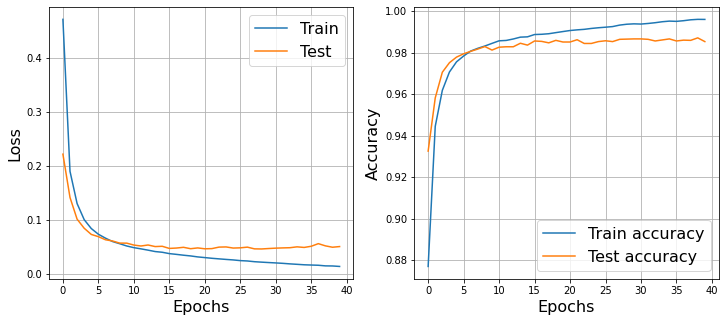

CPU times: user 9min 42s, sys: 5.66 s, total: 9min 48s
Wall time: 9min 56s


In [8]:
%%time
network = ConvClassifier1()
train(network, train_loader, test_loader, 40, 0.0001, loss=nn.NLLLoss(),device='cuda')

Epoch 39... (Train/Test) NLL: 0.015/0.049	Accuracy: 0.996/0.986


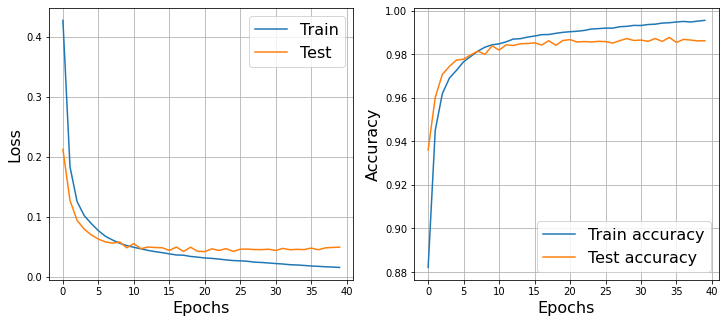

CPU times: user 10min 25s, sys: 4.67 s, total: 10min 30s
Wall time: 10min 32s


In [10]:
%%time3нн
network = ConvClassifier2()
train(network, train_loader, test_loader, 40, 0.0001, loss=nn.NLLLoss(),device='cuda')

Результат для этих двух архитектур (0.986) лучше чем получался у полносвязной сети (0.974). Однако у полносвязной сети график лоса и скора гораздо боле плавный (?), хотя lr там гораздо больше (0.01 а здесь 0.0001)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

Wrong y len  145


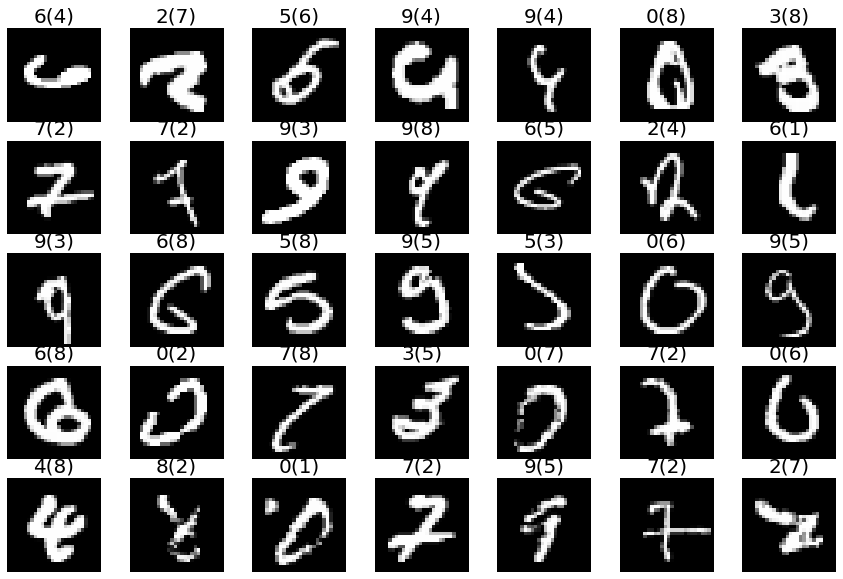

In [78]:
  wrong_X = []
  correct_y = []
  predicted_y = []
  logits = []
  for X, y in test_loader:
      X = X.to('cuda')                                                        
      y = y.to('cuda')     
      network.eval()   
      with torch.no_grad():                                                
        prediction = network.forward(X)
      prediction = prediction.to('cpu').numpy()
      for i in range(len(prediction)):
          if np.argmax(prediction[i]) != y[i]:
              wrong_X.append(X[i].to('cpu').numpy())
              correct_y.append(y[i].to('cpu').numpy())
              predicted_y.append(np.argmax(prediction[i]))
              logits.append(prediction[i][y[i]])
  wrong_X = np.row_stack(wrong_X)
  correct_y = np.row_stack(correct_y)[:, 0]
  predicted_y = np.row_stack(predicted_y)[:, 0]
  logits = np.row_stack(logits)[:, 0]
  plt.figure(figsize=(15, 10))
  order = np.argsort(logits)
  for i in range(35):
      plt.subplot(5, 7, i+1)
      plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
      plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
      plt.axis('off')
  print('Wrong y len ',len(wrong_X))

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

Если сделать упор не на ширину картинки, а на глубину (использовать свертки с большим колличество каналов и больше пулинга) то реультат получается лучше: скор выше и график теста ближе к трейну, то есть меньше переобучение):

Epoch 39... (Train/Test) NLL: 0.012/0.041	Accuracy: 0.996/0.988


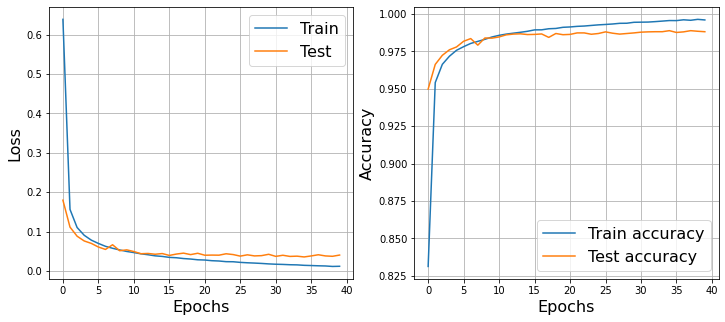

CPU times: user 10min 21s, sys: 4.13 s, total: 10min 25s
Wall time: 10min 28s


In [19]:
%%time
network = ConvClassifier3()
train(network, train_loader, test_loader, 40, 0.0001, loss=nn.NLLLoss(),device='cuda')

Добавление линейных слоев вроде бы еще снижает переобучение (в среднем график тест ближе к трейну), но в то же время график теста колеблется, скор нестабилен:

Epoch 39... (Train/Test) NLL: 0.013/0.037	Accuracy: 0.996/0.988


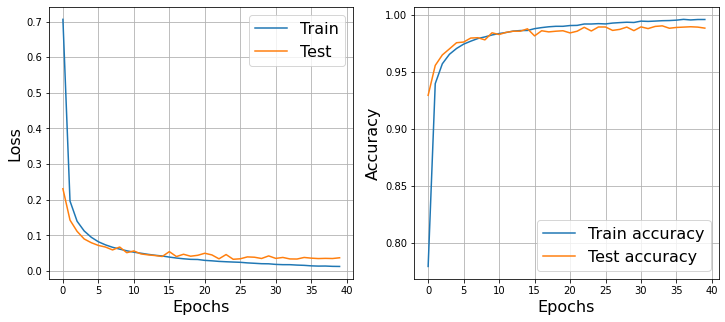

CPU times: user 10min 29s, sys: 4.16 s, total: 10min 34s
Wall time: 10min 36s


In [35]:
%%time
network = ConvClassifier4()
train(network, train_loader, test_loader, 40, 0.0001, loss=nn.NLLLoss(),device='cuda')

Попробуем уменьшить lr и увеличить колличество эпох

Epoch 79... (Train/Test) NLL: 0.009/0.042	Accuracy: 0.997/0.988


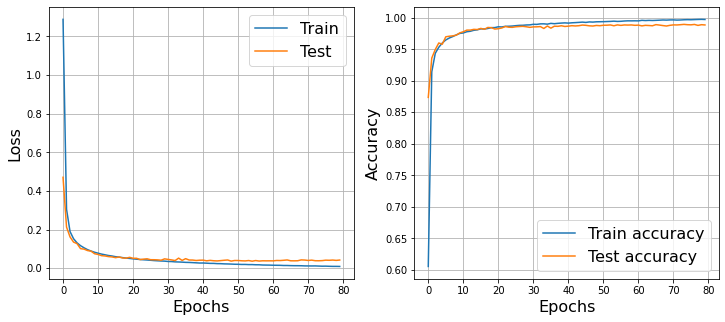

CPU times: user 20min 42s, sys: 8.09 s, total: 20min 50s
Wall time: 20min 56s


In [38]:
%%time
network = ConvClassifier4()
train(network, train_loader, test_loader, 80, 0.00005, loss=nn.NLLLoss(),device='cuda')

То есть линейные слои ничего не дали. 
Так же можно сделать вывод, что скорее всего выгоднее уменьшать размер картинки и наращивать глубину каналов (при том же колличестве нейронов)
Так же заметно, что полносвязные сети учатся стабильнее (имею в виду, что графики более плавные),даже c гораздо большим lr, не могу предположить с чем это связано. Но скор у них конечно гораздно ниже. 